# UNCOVERING INCOME TAX FRAUD: A LOGISTIC REGRESSION APPROACH FOR DETECTION AND PREVENTION

# Data Pre-processing

In [58]:
# Loading the OpenML Income Dataset
import pandas as pd
income_data = pd.read_csv("census-income (1).csv")

In [60]:
# Displaying first 5 rows
income_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [62]:
# Structure of the dataset
income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [64]:
# No of rows and columns
income_data.shape

(48842, 15)

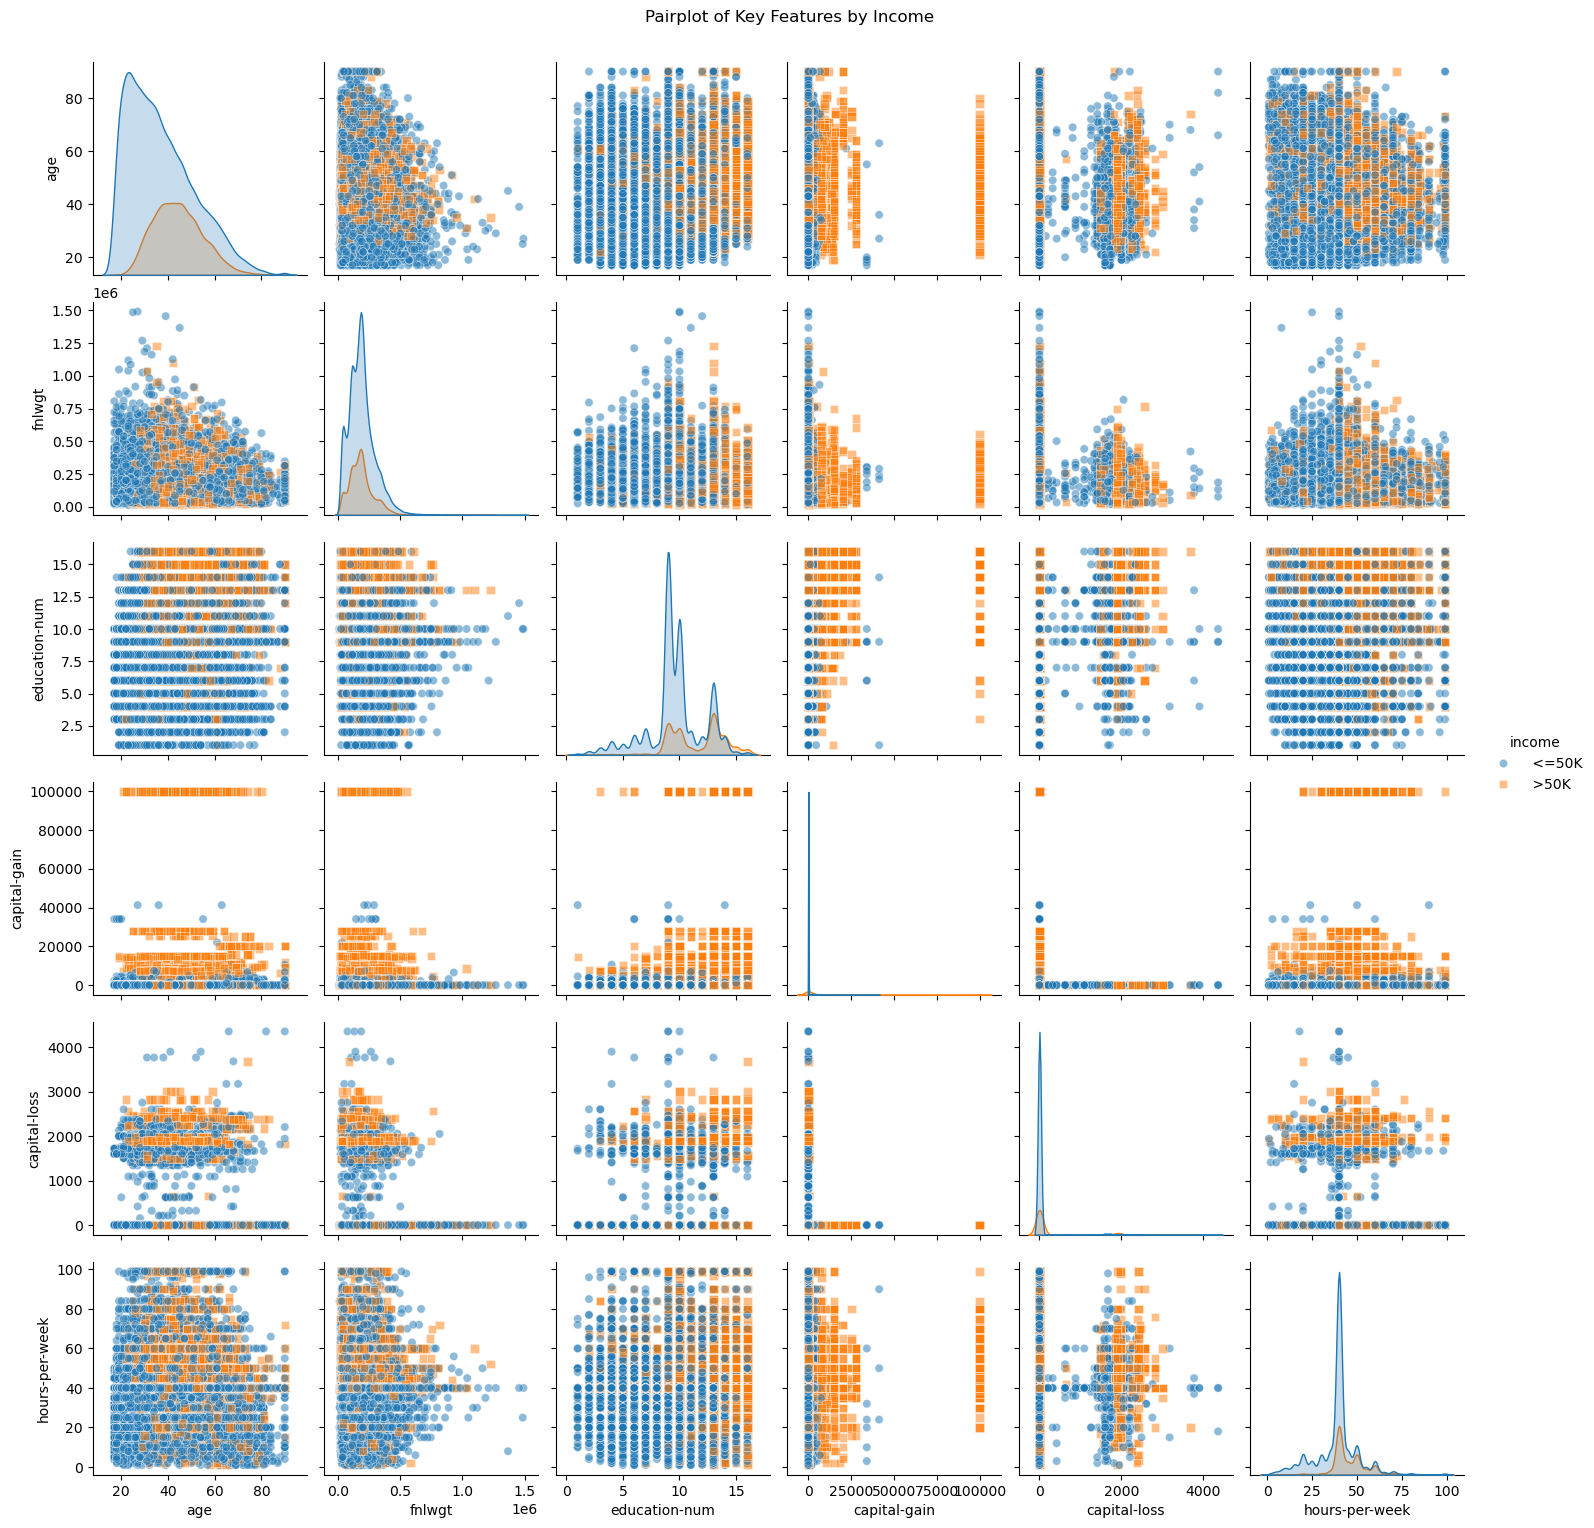

In [70]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Perform EDA with pairplot
sns.pairplot(income_data[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']], 
             hue='income', 
             diag_kind='kde',  # Optional: makes diagonal plots smoother
             markers=["o", "s"],  # Different markers for each class
             plot_kws={'alpha': 0.5})  # Transparency for better visibility

plt.suptitle('Pairplot of Key Features by Income', y=1.02)  # Add a title
plt.show()


In [74]:
# Ensure relevant features exist in the DataFrame
relevant_features = [
    'age', 'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'hours-per-week', 'native-country', 'income'
]

# Filter only the relevant features (ignores missing columns)
income_data = income_data[[col for col in relevant_features if col in income_data.columns]]

# Check the result
print(f"Selected {income_data.shape[1]} features.")
print(income_data.head())


Selected 11 features.
   age   workclass      education       marital-status          occupation  \
0   25     Private           11th        Never-married   Machine-op-inspct   
1   38     Private        HS-grad   Married-civ-spouse     Farming-fishing   
2   28   Local-gov     Assoc-acdm   Married-civ-spouse     Protective-serv   
3   44     Private   Some-college   Married-civ-spouse   Machine-op-inspct   
4   18           ?   Some-college        Never-married                   ?   

  relationship    race      sex  hours-per-week  native-country  income  
0    Own-child   Black     Male              40   United-States   <=50K  
1      Husband   White     Male              50   United-States   <=50K  
2      Husband   White     Male              40   United-States    >50K  
3      Husband   Black     Male              40   United-States    >50K  
4    Own-child   White   Female              30   United-States   <=50K  


Demographic factors - [Age, Workclass, Race, Sex, Native-country, Income]

Behavioral factors - [Education, Marital-status, Occupation, Relationship, Hours-per-week]

# Data Splitting

In [78]:
# Import necessary library
from sklearn.model_selection import train_test_split

# Ensure 'income' exists before dropping
if 'income' in income_data.columns:
    X = income_data.drop('income', axis=1)
    y = income_data['income']
else:
    raise ValueError("'income' column not found in the dataset.")

# Split the dataset into 80% training and 20% testing, with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Confirm the split
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 39073 samples
Testing set size: 9769 samples


Encode categorical variables and Scale the numerical variables

In [81]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

# Identify categorical and numerical columns
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

# Check for empty categorical or numerical columns
if not categorical_cols:
    print("No categorical columns found.")
if not numerical_cols:
    print("No numerical columns found.")

# Define column transformer with both scaler and encoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Keeps any unexpected columns (optional)
)

# Fit and transform the training data, transform the testing data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Optional: Convert back to DataFrame if needed
if categorical_cols:
    encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
else:
    encoded_cols = []

column_names = numerical_cols + list(encoded_cols)
X_train = pd.DataFrame(X_train.toarray() if hasattr(X_train, "toarray") else X_train, columns=column_names)
X_test = pd.DataFrame(X_test.toarray() if hasattr(X_test, "toarray") else X_test, columns=column_names)

# Confirm transformation
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")


X_train shape: (39073, 104), X_test shape: (9769, 104)


# Training models

In [84]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import warnings
import numpy as np
warnings.filterwarnings('ignore')

# Define models
models = [
    ("Logistic Regression", LogisticRegression(random_state=42, max_iter=1000, solver='saga')),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Feed Forward Neural Network", MLPClassifier(random_state=42, max_iter=1000)),
    ("k-Nearest Neighbors", KNeighborsClassifier()),
    ("Naive Bayes", GaussianNB())
]

# Convert to dense only if necessary (for specific models)
dense_required = {'Decision Tree', 'Random Forest', 'k-Nearest Neighbors', 'Naive Bayes'}
if any(name in dense_required for name, _ in models):
    X_train = X_train.toarray() if hasattr(X_train, "toarray") else X_train
    X_test = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# Train models
for name, model in models:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
        print(f"{name} training complete.")

print("All models trained successfully.")


Logistic Regression training complete.
Decision Tree training complete.
Random Forest training complete.
Feed Forward Neural Network training complete.
k-Nearest Neighbors training complete.
Naive Bayes training complete.
All models trained successfully.


# Model Evaluation

In [109]:
# Import necessary libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Initialize results dictionary
results = {}

# Evaluate each model
for name, model in models:
    y_pred = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label=' >50K', zero_division=0),
        'Recall': recall_score(y_test, y_pred, pos_label=' >50K', zero_division=0),
        'F1-score': f1_score(y_test, y_pred, pos_label=' >50K', zero_division=0)
    }

# Convert results to DataFrame and round for readability
results_df = pd.DataFrame(results).T.round(4)

# Display results
print("Model Performance Metrics:")
print(results_df)


Model Performance Metrics:
                             Accuracy  Precision  Recall  F1-score
Logistic Regression            0.8408     0.7127  0.5612    0.6279
Decision Tree                  0.7877     0.5598  0.5282    0.5436
Random Forest                  0.8170     0.6390  0.5406    0.5857
Feed Forward Neural Network    0.8151     0.6060  0.6506    0.6275
k-Nearest Neighbors            0.8229     0.6439  0.5817    0.6112
Naive Bayes                    0.6092     0.3721  0.9204    0.5299


# Visualisation

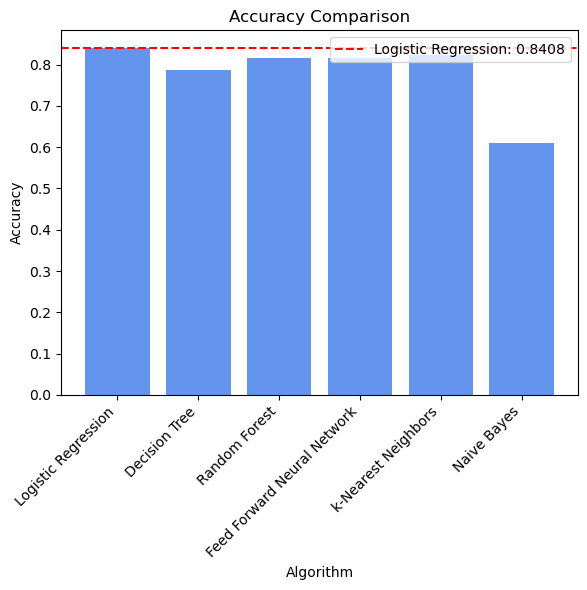

In [123]:
import matplotlib.pyplot as plt

# Ensure 'Logistic Regression' is referenced correctly
if 'Logistic Regression' in results_df.index:
    lr_accuracy = results_df.loc['Logistic Regression', 'Accuracy']
else:
    lr_accuracy = None

# Plotting
plt.figure(figsize=(6, 6))
plt.bar(results_df.index, results_df['Accuracy'], color='cornflowerblue')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks(rotation=45, ha='right')

# Add a horizontal line for Logistic Regression accuracy if found
if lr_accuracy is not None:
    plt.axhline(y=lr_accuracy, color='r', linestyle='--', label=f'Logistic Regression: {lr_accuracy:.4f}')

plt.legend()
plt.tight_layout()
plt.show()


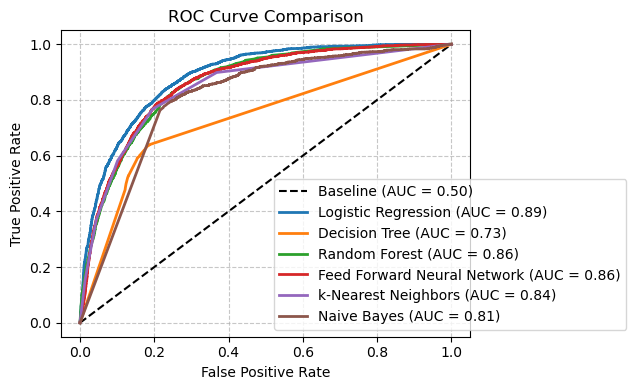

In [135]:
#ROC curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import numpy as np

# Convert categorical labels to binary (handle class imbalance explicitly)
# Explicitly define positive class as '>50K' to avoid LabelEncoder issues
y_test_binary = np.where(y_test == ' >50K', 1, 0)

plt.figure(figsize=(7, 4))

# Plot baseline (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Baseline (AUC = 0.50)')

# Plot ROC curve for each model
for name, model in models:
    # Check if model supports probability estimates
    if not hasattr(model, 'predict_proba'):
        print(f"Model {name} doesn't support predict_proba - skipping")
        continue

    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_binary, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot with AUC in label
    plt.plot(fpr, tpr,
             label=f'{name} (AUC = {roc_auc:.2f})',
             linewidth=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0))  # Place legend outside plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



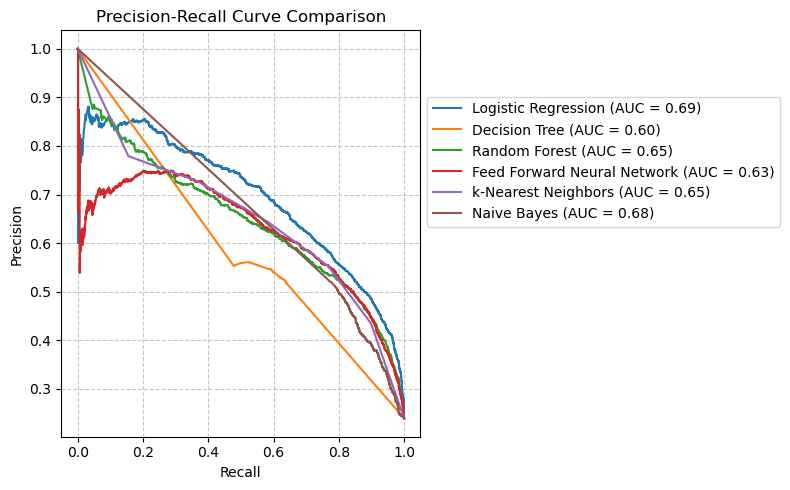

In [147]:
#Precision-Recall Curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Convert target variable to binary format if not already done
# Assuming '>50K' is the positive class (1), others are 0
y_test_binary = (y_test == ' >50K').astype(int)

plt.figure(figsize=(8, 5))

# Plot PR curve for each model
for name, model in models:
    # Get prediction scores
    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_scores = model.decision_function(X_test)
    else:
        print(f"Model {name} doesn't support probability estimates")
        continue

    # Calculate PR curve
    precision, recall, _ = precision_recall_curve(y_test_binary, y_scores)
    pr_auc = auc(recall, precision)

    # Plot with AUC in label
    plt.plot(recall, precision,
             label=f'{name} (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))  # Improved legend placement
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [48]:
# Import necessary libraries
from sklearn.model_selection import cross_val_score
import numpy as np

# Assuming 'models' is a list of (name, model) tuples
for name, model in models:
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    print("Model: ", name)
    print(f"Mean cross-validation score: {np.mean(cv_scores):.4f}")
    print(f"Standard deviation: {np.std(cv_scores):.4f}\n")


Model:  Logistic Regression
Mean cross-validation score: 0.8346172945234638
Model:  Decision Tree
Mean cross-validation score: 0.7825865720373295
Model:  Random Forest
Mean cross-validation score: 0.817162880366683
Model:  Feed Forward Neural Network
Mean cross-validation score: 0.8193381089868617
Model:  k-Nearest Neighbors
Mean cross-validation score: 0.8178535874643286
Model:  Naive Bayes
Mean cross-validation score: 0.6050464955559648


# Hyperparameter Tuning

In [51]:
# Import necessary libraries
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for tuning
lr_params = {"C": np.logspace(-3, 3, 7)}

# Set up GridSearchCV
lr_grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000, solver='saga'),
    lr_params,
    cv=10,
    scoring='accuracy',  # You can change this to 'f1', 'roc_auc', etc.
    n_jobs=-1  # Use all available CPU cores
)

# Fit the model
lr_grid_search.fit(X_train, y_train)

# Extract the best model
best_lr_model = lr_grid_search.best_estimator_

print(f"Best model: {best_lr_model}")
print(f"Best hyperparameters: {lr_grid_search.best_params_}")
print(f"Best cross-validation score: {lr_grid_search.best_score_:.4f}")


Best model: LogisticRegression(C=np.float64(1.0), max_iter=1000, random_state=42,
                   solver='saga')
Best hyperparameters: {'C': np.float64(1.0)}
Best cross-validation score: 0.8346


In [52]:
# Evaluate the performance of the best-performing model
# Generate predictions on the test set using the trained model
y_pred = best_lr_model.predict(X_test)

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred)  # Overall accuracy of predictions
precision = precision_score(y_test, y_pred, pos_label=' >50K')  # Precision for '>50K' class
recall = recall_score(y_test, y_pred, pos_label=' >50K')  # Recall for '>50K' class
f1 = f1_score(y_test, y_pred, pos_label=' >50K')  # F1-score for '>50K' class

# Print model performance report
print(f"Best model performance: {best_lr_model}")  # Display model configuration
print(f"Accuracy: {accuracy}")  # Proportion of correct predictions
print(f"Precision: {precision}")  # Ratio of true positives to all predicted positives
print(f"Recall: {recall}")  # Ratio of true positives to actual positives
print(f"F1 Score: {f1}")  # Harmonic mean of precision and recall
print("")  # Add blank line for readability

Best model performance: LogisticRegression(C=np.float64(1.0), max_iter=1000, random_state=42,
                   solver='saga')
Accuracy: 0.8429726686457161
Precision: 0.7038834951456311
Recall: 0.5698689956331878
F1 Score: 0.6298262548262549



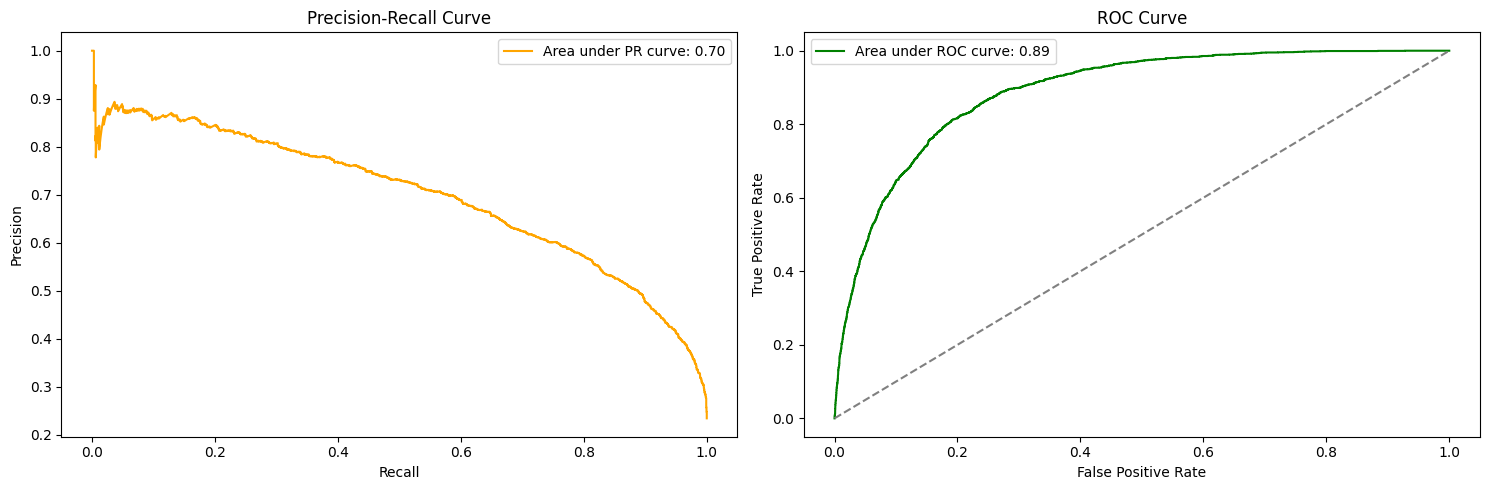

In [53]:

# Fit the model
best_lr_model.fit(X_train, y_train)
y_proba = best_lr_model.predict_proba(X_test)[:, 1]

# Calculate Precision-Recall curve and AUC
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_proba, pos_label=' >50K')
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba, pos_label=' >50K')

# Calculate AUC for ROC and PR curves
roc_auc = auc(fpr, tpr)
pr_auc = average_precision_score(y_test, y_proba, pos_label=' >50K')

# Plot the Precision-Recall curve and the ROC curve
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

# Plot the Precision-Recall curve
ax1.plot(recall, precision, color='orange', label=f"Area under PR curve: {pr_auc:.2f}")
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.legend()

# Plot the ROC curve
ax2.plot(fpr, tpr, color='green', label=f"Area under ROC curve: {roc_auc:.2f}")
ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal for reference
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()

plt.tight_layout()
plt.show()


In [54]:
# Set the threshold for identifying suspicious tax returns
threshold = 0.35  # Chosen probability cutoff for classification
print(f"Threshold for identifying suspicious tax returns: {threshold:.2f}")

# Train the model on the full training dataset (ensure model is properly fitted)
best_lr_model.fit(X_train, y_train)

# Get predicted probabilities for the positive class ('>50K')
y_proba = best_lr_model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions using the threshold
# 1 = suspicious (>=50K), 0 = not suspicious (<=50K)
y_pred = (y_proba >= threshold).astype(int)

# Extract feature values for flagged cases (first 10 features)
# Note: This assumes the first 10 columns in X_test correspond to model features
fraudulent_cases = X_test[y_pred == 1, :10]

# Convert to DataFrame for better readability
fraudulent_cases_df = pd.DataFrame(fraudulent_cases, columns=X.columns[:10])

# Display count of identified suspicious returns
print(f"Number of suspicious tax returns identified: {len(fraudulent_cases)}")




Threshold for identifying suspicious tax returns: 0.35
Number of suspicious tax returns identified: 2769


# Model Comparison

In [55]:
# Compare model performance across different algorithms

# Initialize result tracking lists
model_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate through all models to evaluate performance
for name, model in models:
    # Train model on training data
    model.fit(X_train, y_train)

    # Generate predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=' >50K')  # Note space in label
    recall = recall_score(y_test, y_pred, pos_label=' >50K')
    f1 = f1_score(y_test, y_pred, pos_label=' >50K')

    # Store results
    model_names.append(name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Create final comparison DataFrame outside loop
results_df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})

# Show comparison results
print("Model Performance Comparison:")
print(results_df)



Model Performance Comparison:
                         Model  Accuracy  Precision    Recall  F1 Score
0          Logistic Regression  0.842973   0.703883  0.569869  0.629826
1                Decision Tree  0.787184   0.547077  0.535371  0.541161
2                Random Forest  0.820248   0.629990  0.565066  0.595764
3  Feed Forward Neural Network  0.825366   0.627178  0.628821  0.627998
4          k-Nearest Neighbors  0.823012   0.627442  0.603057  0.615008
5                  Naive Bayes  0.608660   0.366626  0.920087  0.524325


# Model Deployment

In [56]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import os

# Create dummy data and train a simple sklearn model
X, y = make_classification(n_samples=1000, n_features=9, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_lr_model = LogisticRegression().fit(X_train, y_train)

# Define input data to test the TensorFlow Lite model.
input_data = np.array([[0.123, -0.456, -1.234, 0.789, -2.345]])

# Assuming Declaredincome and Actualincome are categorical variables with two possible values.
Declaredincome = '<=50K'  # example value
Actualincome = '>50K'  # example value

if Declaredincome == '<=50K':
    input_data = np.hstack((input_data, [[1, 0]]))
else:
    input_data = np.hstack((input_data, [[0, 1]]))

if Actualincome == '<=50K':
    input_data = np.hstack((input_data, [[1, 0]]))
else:
    input_data = np.hstack((input_data, [[0, 1]]))

# Convert input data to FLOAT32
input_data = input_data.astype(np.float32)

# Convert scikit-learn model to TensorFlow model
input_shape = (9,)
model_input = keras.layers.Input(shape=input_shape, name="input")
model_output = keras.layers.Dense(1, activation="sigmoid", name="output")(model_input)
tf_model = keras.Model(inputs=model_input, outputs=model_output)

# Set the weights of the TensorFlow model
tf_model.layers[1].set_weights([best_lr_model.coef_.T, best_lr_model.intercept_])

# Convert TensorFlow model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to a file in the current directory
file_path = os.path.join(os.getcwd(), 'TFmodel.tflite')
with open(file_path, "wb") as f:
    f.write(tflite_model)

# Create an interpreter for the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=file_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set input data
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get output and reshape to the correct shape
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data = np.reshape(output_data, (1, 1))

# Testing the TensorFlow Lite model
result = '1' if output_data[0][0] > 0.5 else '0'
print(result)


Saved artifact at '/tmp/tmp593o7a_k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 9), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133087950702928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133087950705424: TensorSpec(shape=(), dtype=tf.resource, name=None)
1


In [ ]:
########################################################## END ################################################################